# Occlusion development

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
import math
import open3d as o3d

In [3]:
def get_identity_transform():
    return np.eye(4, 4, dtype=np.float64)

In [4]:
@dataclass
class Camera:
    f_x: float
    f_y: float
    c_x: float
    c_y: float
    s: float = 0.0
    T_camera_world: np.ndarray = field(default_factory=get_identity_transform)

    @property
    def calibration_matrix(self) -> np.ndarray:
        return np.array([[self.f_x, self.s, self.c_x], [0, self.f_y, self.c_y], [0, 0, 1]], dtype=float)
    
    def set_transform(self, T: np.ndarray):
        self.T_camera_world = T

    @property
    def camera_matrix(self):
        C = get_identity_transform()
        C[:3, :3] = self.calibration_matrix
        return C @ self.T_camera_world

    @classmethod
    def from_screensize(cls, W: int, H: int, f: float) -> "Camera":
        return cls(f, f, W//2, H//2, 0)

In [50]:
W = 1600
H = 900
horizontal_fov_degrees = 60
horizontal_fov_rad = math.radians(horizontal_fov_degrees)
f = W/2 * 1/(math.tan(horizontal_fov_rad/2))

camera = Camera.from_screensize(W, H, f)

In [51]:
f

1385.6406460551023

In [52]:
T_w_c = get_identity_transform()
T_w_c[:3, 0] = [0, -1, 0]
T_w_c[:3, 1] = [0, 0, 1]
T_w_c[:3, 2] = [-1, 0, 0]
T_w_c[:3, 3] = [0, 0, 1.0]
T_c_w = np.linalg.inv(T_w_c)
camera.set_transform(T_c_w)

In [53]:
camera.calibration_matrix

array([[1.38564065e+03, 0.00000000e+00, 8.00000000e+02],
       [0.00000000e+00, 1.38564065e+03, 4.50000000e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [54]:
C = camera.camera_matrix

In [55]:
C

array([[-8.00000000e+02, -1.38564065e+03,  0.00000000e+00,
         0.00000000e+00],
       [-4.50000000e+02,  0.00000000e+00,  1.38564065e+03,
        -1.38564065e+03],
       [-1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [56]:
triangle_in_world = np.array([
    [10, -1, 1],
    [10, 1, 1],
    [10, 0, 2]
])

In [57]:
triangle2_in_world = np.array([
    [20, 0, 1],
    [20, 2, 1],
    [20, 1, 2]
])

In [58]:
triangle_in_world_homogenous = np.r_[triangle_in_world.T, np.ones((1, triangle_in_world.shape[0]), dtype=float)]
triangle_in_world_homogenous

array([[10., 10., 10.],
       [-1.,  1.,  0.],
       [ 1.,  1.,  2.],
       [ 1.,  1.,  1.]])

In [59]:
triangle2_in_world_homogenous = np.r_[triangle2_in_world.T, np.ones((1, triangle2_in_world.shape[0]), dtype=float)]
triangle2_in_world_homogenous

array([[20., 20., 20.],
       [ 0.,  2.,  1.],
       [ 1.,  1.,  2.],
       [ 1.,  1.,  1.]])

In [60]:
pts_unnormalized = C @ triangle_in_world_homogenous
pts_unnormalized /= pts_unnormalized[2, :]
pts_unnormalized

array([[ 6.61435935e+02,  9.38564065e+02,  8.00000000e+02],
       [ 4.50000000e+02,  4.50000000e+02,  3.11435935e+02],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [-1.00000000e-01, -1.00000000e-01, -1.00000000e-01]])

In [61]:
z_values = 1/pts_unnormalized[3, :]
z_values

array([-10., -10., -10.])

In [62]:
pts2_unnormalized = C @ triangle2_in_world_homogenous
pts2_unnormalized /= pts2_unnormalized[2, :]

In [63]:
z2_values = 1/pts2_unnormalized[3, :]
z2_values

array([-20., -20., -20.])

In [64]:
pts2_unnormalized

array([[ 8.00000000e+02,  9.38564065e+02,  8.69282032e+02],
       [ 4.50000000e+02,  4.50000000e+02,  3.80717968e+02],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [-5.00000000e-02, -5.00000000e-02, -5.00000000e-02]])

In [65]:
t = pts_unnormalized.astype(int).T[:, :2]
t2 = pts2_unnormalized.astype(int).T[:, :2]

In [66]:
t_inverted = np.c_[t[:, 0], H-t[:, 1]]
t2_inverted = np.c_[t2[:, 0], H-t2[:, 1]]

In [67]:
t_inverted


array([[661, 450],
       [938, 450],
       [800, 589]])

In [68]:
from shapely import Polygon, box, GeometryCollection, Point

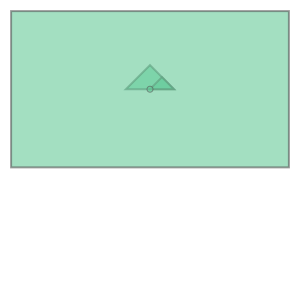

In [69]:
GeometryCollection([Polygon(t_inverted), Polygon(t2_inverted), box(0, 0, W, H), Point(W/2, H/2)])

In [70]:
from src.trast import Rasterizer

In [71]:
r = Rasterizer(screen=(W, H), pixel=255)

In [72]:
r.rasterize_triangle(face=t2_inverted)

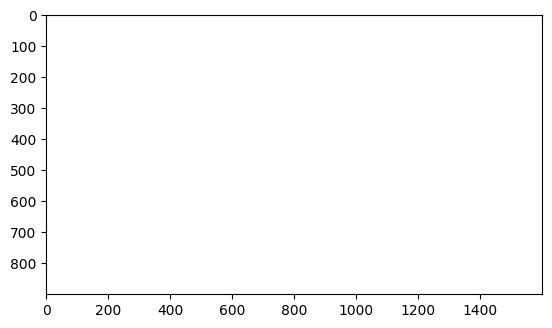

In [73]:
r.quick_plot()

## Create a more realistic scene

In [74]:
from scipy.spatial.transform import Rotation as R

In [75]:
o3d.geometry.TriangleMesh.create_sphere?

Docstring:
create_sphere(radius=1.0, resolution=20, create_uv_map=False)
Factory function to create a sphere mesh centered at (0, 0, 0).

Args:
    radius (float, optional, default=1.0): The radius of the sphere.
    resolution (int, optional, default=20): The resolution of the sphere. The longitues will be split into ``resolution`` segments (i.e. there are ``resolution + 1`` latitude lines including the north and south pole). The latitudes will be split into ```2 * resolution`` segments (i.e. there are ``2 * resolution`` longitude lines.)
    create_uv_map (bool, optional, default=False): Add default uv map to the mesh.

Returns:
    open3d.geometry.TriangleMesh
Type:      builtin_function_or_method

In [76]:
sphere1_mesh = o3d.geometry.TriangleMesh.create_sphere(radius=1, resolution=40)
sphere2_mesh = o3d.geometry.TriangleMesh.create_sphere(radius=1, resolution=40)

In [77]:
def create_trafo_matrix(tranlation: tuple[float, float], yaw_deg: float = 0.0):
    T = get_identity_transform()

    r = R.from_euler('z', yaw_deg, degrees=True)
    T[:3, :3] = r.as_matrix()

    T[:3, 3] = np.array(tranlation)
    return T

In [78]:
T_world_sphere1 = create_trafo_matrix((8, 0, 1), 0.0)
T_world_sphere2 = create_trafo_matrix((10, 0.5, 1.5), 0.0)  # 3m behind

In [79]:
sphere1_mesh_world = sphere1_mesh.transform(T_world_sphere1)
sphere2_mesh_world = sphere2_mesh.transform(T_world_sphere2)

In [80]:
sphere1_mesh_world.compute_vertex_normals()
sphere2_mesh_world.compute_vertex_normals()

TriangleMesh with 3122 points and 6240 triangles.

In [81]:
# o3d.visualization.draw([sphere1_mesh_world, sphere2_mesh_world], raw_mode=True)

In [82]:
mesh1_vertices = np.asarray(sphere1_mesh_world.vertices)
mesh2_vertices = np.asarray(sphere2_mesh_world.vertices)

In [83]:
def transform_with_camera_matrix(C: np.ndarray, points: np.ndarray, normalize = True):

    num_points = points.shape[0]
    points_with_ones_column = np.r_[points.T, np.ones((1, num_points), dtype=float)]

    pts_transformed = C @ points_with_ones_column
    # normalize
    pts_transformed /= pts_transformed[2, :]
    return pts_transformed.T

In [84]:
mesh1_vertices_screen = transform_with_camera_matrix(C, mesh1_vertices)
mesh2_vertices_screen = transform_with_camera_matrix(C, mesh2_vertices)

In [85]:
mesh1_vertices_screen[:, 1] = H-mesh1_vertices_screen[:, 1]
mesh2_vertices_screen[:, 1] = H-mesh2_vertices_screen[:, 1]
mesh1_vertices_screen[:, 0] = W-mesh1_vertices_screen[:, 0]
mesh2_vertices_screen[:, 0] = W-mesh2_vertices_screen[:, 0]

In [86]:
mesh1_vertices_screen[:, 1].min(), mesh1_vertices_screen[:, 1].max()

(275.51543628170145, 624.4845637182987)

In [87]:
mesh1_vertices_screen[:, 3].min(), mesh1_vertices_screen[:, 3].max()

(-0.14285714285714285, -0.1111111111111111)

In [88]:
mesh2_vertices_screen[:, 3].min(), mesh2_vertices_screen[:, 3].max()

(-0.1111111111111111, -0.09090909090909091)

In [89]:
from tqdm import tqdm

In [90]:
r = Rasterizer(screen=(W, H), pixel=255)

for triangle_indices in tqdm(sphere1_mesh.triangles, total=len(sphere1_mesh.triangles)):
    vertices_triangle = mesh1_vertices_screen[triangle_indices, :]
    vertices_triangle_xy = vertices_triangle[:, :2]
    vertices_triangle_z = vertices_triangle[:, 3]

    avg_z_value = vertices_triangle_z.mean()
    r.rasterize_triangle(vertices_triangle_xy, avg_z_value)

for triangle_indices in tqdm(sphere2_mesh.triangles, total=len(sphere2_mesh.triangles)):
    vertices_triangle = mesh2_vertices_screen[triangle_indices, :]
    vertices_triangle_xy = vertices_triangle[:, :2]
    vertices_triangle_z = vertices_triangle[:, 3]

    avg_z_value = vertices_triangle_z.mean()
    r.rasterize_triangle(vertices_triangle_xy, avg_z_value)

100%|██████████| 6240/6240 [00:00<00:00, 35523.58it/s]


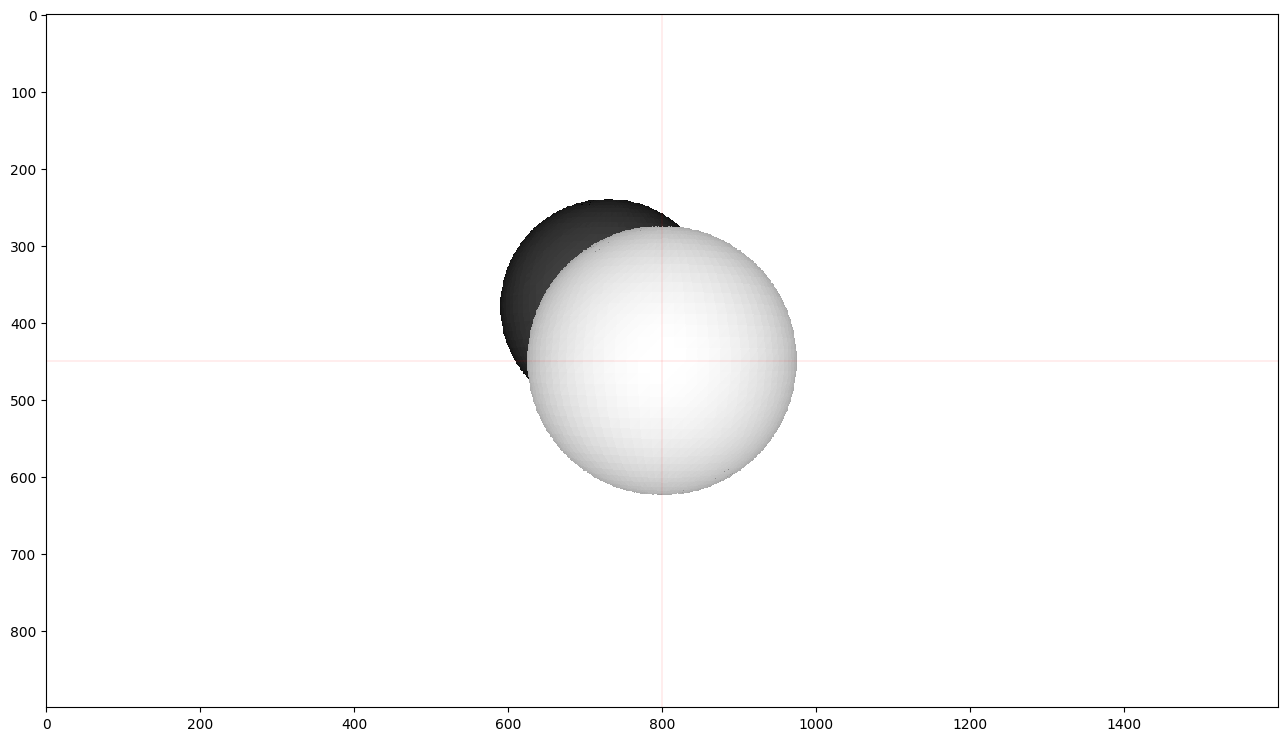

In [92]:
plt.figure(figsize=(16, 9))
plt.imshow(r._screen, cmap=plt.cm.gray_r, origin='upper', interpolation="nearest", vmax=None)

ax = plt.gca()
ax.axhline(H/2, color="red", lw=0.1)
ax.axvline(W/2, color="red", lw=0.1)